# CHORDictor

## Description

### Project Scope
A Python program that can automatically annotate the jazz chord progressions for a MIDI file. For any ambiguous chords or sections which the program cannot determine an annotation for, the program will flag them and the human user can manually enter the corresponding label to ensure the annotation accuracy.

### Data
* Jazz Piano MIDI Multitracks
* Size: 310 MIDI files
* Source: https://bushgrafts.com/midi/

## Member Contributions

### Brandon Carone
* Initial scope of the project
* MIDI data loading and parsing
* Manually created MIDI Chord Templates - 33 chords in 12 keys
* Mapping notes to chords (templates)

### Kenny Huang
* MIDI data loading, parsing, & visualizing
* Selected method of parsing MIDI file (mido over music21)
* Converted key format from music21 to librosa
* Converted accidentals formatting
* Obtained music21's in-build chord-detection algorithm
* Helped write some MIDI processing functions
* Wrote music21 chord identification function wrapper

### Richa Namballa
* Formatted and documented code
* Wrote helper functions
* Quantized MIDI file
* Time-aligned MIDI parsing
* Converted MIDI to note names
* Extracted timestamps of each note
* Separated notes into individual beats
* Modularized code
* Programmed demo

## Install & Import Libraries

In [ ]:
!pip install mido
!pip install music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

In [ ]:
import os
import copy
import numpy as np
import pandas as pd
import librosa
import mido
import re
import matplotlib.pyplot as plt
from glob import glob
from music21 import midi, chord, pitch
from tqdm import tqdm

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# upload the jazz_midi folder to mir_datasets folder in Drive
midi_dir = '/content/drive/MyDrive/mir_datasets/jazz_midi/*.mid'
midi_files = []
for midi_file in tqdm(glob(midi_dir)):
    midi_files.append(midi_file)
midi_files.sort()

100%|██████████| 302/302 [00:00<00:00, 708830.33it/s]


## Data Preprocessing

### Helper Functions

In [ ]:
def quantize_file(midi_file_path, out_path, divisor=8, offsets=True, durations=True):
    """
    Quantize the inputted MIDI file.
    
    :param midi_file_path: (str) path to MIDI file to be quantized
    :param out_path: (str) path to written quantized MIDI file
    :param divisor: (int) the subdivision of a quarter note to quantize to,
                    the default value is 8, which corresponds to a 1/32nd note
    :param offets: (bool) whether to quantize the note offsets
    :param durations: (bool) where to quantize the note durations
    """
    # read MIDI file
    mf = midi.MidiFile()
    mf.open(midi_file_path, 'rb')
    mf.read()
    mf.close()
    
    # convert to stream for quantization
    s = midi.translate.midiFileToStream(mf)
    # quantize so that all notes are aligned to and within the beat
    s.quantize((divisor,),
               processOffsets=offsets,
               processDurations=durations,
               inPlace=True, recurse=True)
    
    # save to new MIDI file
    mf_quant = midi.translate.streamToMidiFile(s)
    
    mf_quant.open(out_path, 'wb')
    mf_quant.write()
    mf_quant.close()

In [ ]:
def load_midi(midi_file_path, quantize=True):
    """
    Loads MIDI file using mido.
    
    :param midi_file_path: (str) path to MIDI file
    :param quantize: (bool) whether to quantize the MIDI file
    :return: (MidiFile) mido MIDI file object
    """
    if quantize:
        # create a temporary MIDI file with quantization
        quantize_file(midi_file_path, 'temp.mid')
        # load
        mid = mido.MidiFile('temp.mid')
        print(f'Temporary MIDI file created at {os.path.abspath("temp.mid")}')
        # remove temporary file
        os.remove('temp.mid')
        print(f'Removed temporary file.')
        if os.path.exists('temp.mid'):
            print('Unable to remove temporary MIDI file!')
    else:
        # load
        mid = mido.MidiFile(midi_file_path)
    return mid

In [ ]:
def get_tempo(mid):
    """
    Determine tempo of the MIDI file.
    
    :param mid: (MidiFile) mido MIDI file object
    :return: (int) tempo in microseconds per beat
    """
    tempo_list = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                 tempo_list.append(msg.tempo)

    if len(tempo_list) > 0:
        # return the first tempo
        return tempo_list[0]
    else:
        # default tempo from mido
        return 500000

In [ ]:
def get_bpm(mid):
    """
    Determine the BPM of the MIDI file
    
    :param mid: (MidiFile) mido MIDI file object
    :return: (int) BPM
    """
    # compute tempo
    tempo = get_tempo(mid)
    # convert tempo to BPM and round to the nearest integer
    bpm = round(mido.tempo2bpm(tempo))
    return bpm

In [ ]:
def get_metadata(mid):
    """
    Print metadata from MIDI file
    
    :param mid: (MidiFile) mido MIDI file object
    """
    for track in mid.tracks:
        for msg in track:
            if msg.is_meta:
                # only print the message if it is metadata
                print(msg)
    else:
        pass

In [ ]:
def remove_octave(note):
    """
    Strips the octave number from a note.
    
    :param note: (str) note in string form (e.g. 'C5')
    :return: (str) note without octave (e.g. 'C')
    """
    # remove digits from the string
    chars = [i for i in note if not i.isdigit()]
    # rejoin characters
    note_without_octave = ''.join(chars)
    return note_without_octave

### Using `mido` to Read MIDI Files

In [ ]:
# adapted from:
# https://stackoverflow.com/questions/63105201/python-mido-how-to-get-note-starttime-stoptime-track-in-a-list

# midi file to array
def midi_parser(mid):
    """
    Converts a mido MIDI file into an array of note on/off with timestamps

    :param mid: (MidiFile) MIDI file object loaded with mido
    :return: (np.ndarray) array of [type, note, time, channel]
    """
    midi_array = []
    
    # get the tempo in microseconds per beat
    tempo = get_tempo(mid)
    
    # find how many ticks are in a single beat
    tpb = mid.ticks_per_beat

    # iterate through each track individually
    for track in mid.tracks:
        track_info = {}
        metadata   = {}  # track metadata
        note_array = []  # track specific note information
        midi_dict  = []  # a list of dictionaries
        
        # iterate through each message in the track
        for msg in track:
            # TODO: check whether there are other types of messages
            # if (msg.type == 'note_on' or msg.type == 'note_off' or msg.type == 'control_change'):
            if not msg.is_meta:
                # put all note on/off in midinote as dictionary
                midi_dict.append(msg.dict())
            elif msg.type == 'track_name':
                # save the track name as metadata
                metadata['name'] = msg.name
            elif msg.type == 'time_signature':
                # save the time signature as metadata
                metadata['time_signature'] = f'{msg.numerator}/{msg.denominator}'
            elif msg.type == 'key_signature':
                # save the key as metadata
                metadata['key'] = msg.key
            else:
                pass
        
        # add the metadata information
        track_info['metadata'] = metadata

        # change time values from delta to relative time
        event_start = 0
        for d in midi_dict:
            time_in_s = mido.tick2second(d['time'], tpb, tempo)
            time = time_in_s + event_start
            d['time'] = time
            event_start += time_in_s

            # make every note_on with 0 velocity note_off
            if d['type'] == 'note_on' and d['velocity'] == 0:
                d['type'] = 'note_off'

            # put note, starttime, stoptime, as nested list in a list
            # format is [type, note, time, channel]
            event = []
            if d['type'] == 'note_on' or d['type'] == 'note_off':
                # do not include control change values
                event.append(d['type'])
                event.append(d['note'])
                event.append(d['time'])
                event.append(d['channel'])
                note_array.append(event)
        
        # add the note information
        track_info['note_data'] = note_array
        
        # add track to entire midi file array
        midi_array.append(track_info)

    return midi_array

_**Example: "A Sleepin' Bee.mid"**_

In [ ]:
# parsing an example MIDI file
mid_file   = midi_files[1]  # example file: "A Sleepin' Bee.mid"
mid        = load_midi(mid_file, quantize=True)
midi_array = midi_parser(mid)

Temporary MIDI file created at /content/temp.mid
Removed temporary file.


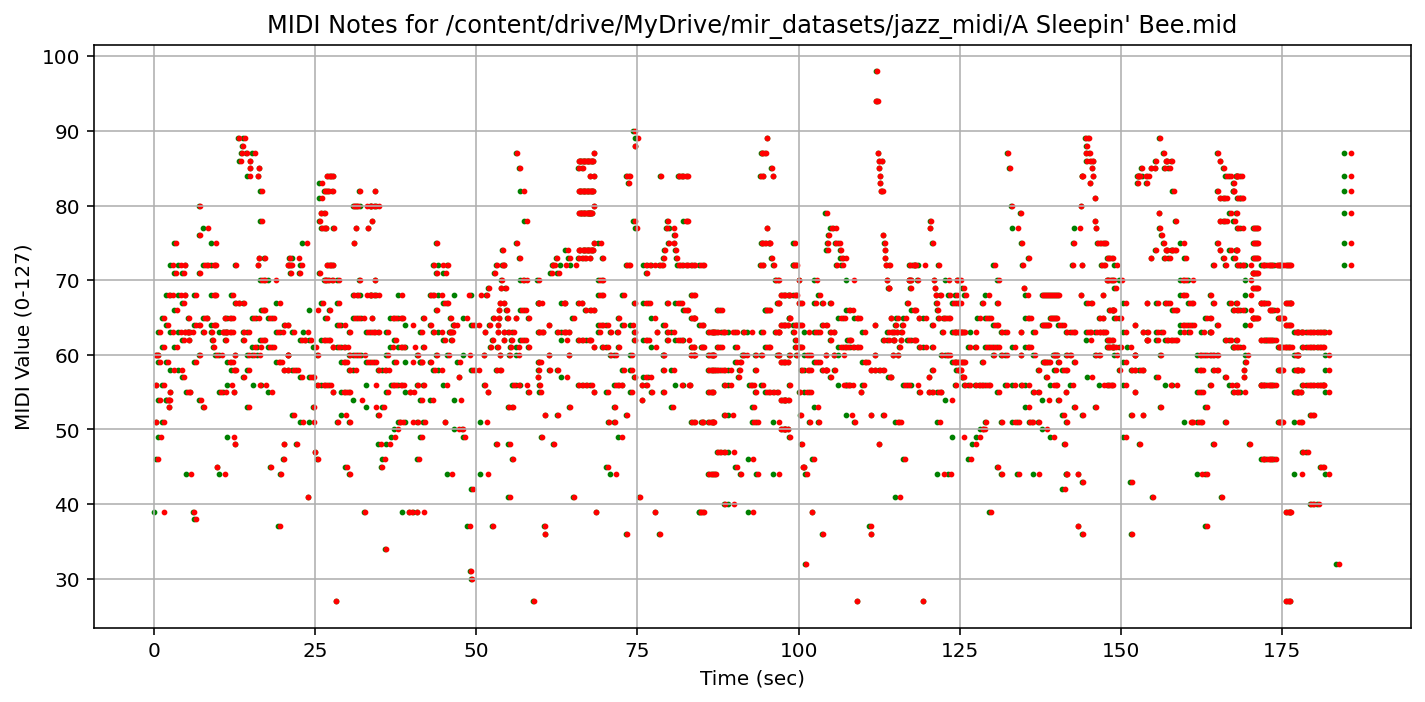

In [ ]:
# find track with note data
for i in range(len(midi_array)):
    if 'note_data' in midi_array[i].keys():
      tr = i
      break

# assigning plot vectors
note_on_values  = [row[1] for row in midi_array[tr]['note_data'] if row[0] == 'note_on']
note_on_times   = [row[2] for row in midi_array[tr]['note_data'] if row[0] == 'note_on']
note_off_values = [row[1] for row in midi_array[tr]['note_data'] if row[0] == 'note_off']
note_off_times  = [row[2] for row in midi_array[tr]['note_data'] if row[0] == 'note_off']

# plotting MIDI
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(note_on_times, note_on_values, s=3.5, color='green')
ax.scatter(note_off_times, note_off_values, s=3.5, color='red')
ax.set(title=f'MIDI Notes for {mid_file}')
ax.set(ylabel='MIDI Value (0-127)')
ax.set(xlabel='Time (sec)')
ax.grid(visible='on', which='both')
fig.tight_layout()

### Convert MIDI to Note Name

In [ ]:
def convert_key_format(midi_array):
    """
    Convert key from mido format to librosa format.
    
    :param midi_array: (list) parsed MIDI array
    :return: (str) converted key in librosa format (e.g. C:maj)
    """
    # a total of 30 applicable music key signatures
    # A Am    A#m Ab Abm 
    # B Bm        Bb Bbm 
    # C Cm C# C#m Cb 
    # D Dm    D#m Db 
    # E Em        Eb Ebm 
    # F Fm F# F#m 
    # G Gm    G#m Gb 
    chord_keys = {'A':'A:maj', 'Am':'A:min',                'A#m':'A#:min', 'Ab':'Ab:maj', 'Abm':'Ab:min',
                  'B':'B:maj', 'Bm':'B:min',                                'Bb':'Bb:maj', 'Bbm':'Bb:min',
                  'C':'C:maj', 'Cm':'C:min', 'C#':'C#:maj', 'C#m':'C#:min', 'Cb':'Cb:maj',
                  'D':'D:maj', 'Dm':'D:min',                'D#m':'D#:min', 'Db':'Db:maj',
                  'E':'E:maj', 'Em':'E:min',                                'Eb':'Eb:maj', 'Ebm':'Eb:min',
                  'F':'F:maj', 'Fm':'F:min', 'F#':'F#:maj', 'F#m':'F#:min',
                  'G':'G:maj', 'Gm':'G:min',                'G#m':'G#:min', 'Gb':'Gb:maj'}
    
    converted_key_format = 'C:maj'  # default key
    for track in midi_array:
        if 'key' in track['metadata']:
            # find the corresponding librosa key format
            converted_key_format = chord_keys[track['metadata']['key']]
    return converted_key_format

In [ ]:
def convert_notes(midi_array, key=None):
    """
    Convert MIDI integers to note names.
    
    :param arr: (list) parsed MIDI array
    :param key: (str) predetermined key in librosa format
                if not provided, the key is extracted from the MIDI file
    :return: (list) MIDI array with note names in provided key
    """
    arr = copy.deepcopy(midi_array)  # avoid overwriting object
    if key is None:
        midi_key = convert_key_format(arr)
    else:
        midi_key = key
    for track in arr:
        new_data = []
        if len(track['note_data']) > 0:
            for note in track['note_data']:
                # convert MIDI number to note name
                note[1] = librosa.midi_to_note(note[1], key=midi_key)
                new_data.append(note)
            track['note_data'] = new_data
    return arr

_**Example: "A Sleepin' Bee.mid"**_

In [ ]:
note_array = convert_notes(midi_array)

### Chunk the MIDI Data into Beats

In [ ]:
def process_times(data):
    """
    Convert note data to find the onset and offset times for each note, along with its duration.
    
    :param data: (list) note data
    :return: (list) time data
    """
    # convert data to a pandas dataframe
    df = pd.DataFrame(data)
    # label the columns
    df.columns = ['event', 'note', 'time', 'channel']
    # sort the data by note first, then time to get each note on and off in consecutive rows
    df.sort_values(['note', 'time'], inplace=True)
    
    notes    = []
    note_on  = []
    note_off = []
    channel  = []
    
    # group every two rows together (one note on and one note off)
    for i, g in df.groupby(np.arange(len(df)) // 2):
        notes   .append(g.iloc[0, 1])
        note_on .append(g.iloc[0, 2])
        note_off.append(g.iloc[1, 2])
        channel .append(g.iloc[0, 3])

    # create a new dataframe
    df_times = pd.DataFrame({'note': notes, 'time_on': note_on, 'time_off': note_off, 'channel': channel})
    # sort by time to reconstruct the note sequence
    df_times.sort_values(['time_on', 'time_off'], ignore_index=True, inplace=True)
    # compute the duration of each note
    df_times['duration'] = df_times['time_off'] - df_times['time_on']
    # reorder columns
    df_times = df_times[['note', 'time_on', 'time_off', 'duration', 'channel']]
    # convert to list
    times_list = df_times.values.tolist()
    
    return times_list

In [ ]:
def get_notes_by_beat(data, seconds_per_beat, total_time, keep_embellishments=True, subdivision=4):
    """
    Get the notes which are played during each beat.
    
    :param data: (list) note data
    :param seconds_per_beat: (float) length of a beat in seconds
    :param total_time: (float) length of the MIDI file in seconds
    :param keep_embellishments: (bool) whether to keep embellishment tones
                                (e.g. passing or neighboring tones)
    :param subdivision: (int) if keep_embellishments is False, the minimum subdivision
                              of the beat for which a note can be included in the final output
                              (e.g. if subdivision=2 and the timesignature is 4/4, any note
                              less than an eighth note will be dropped)
    :return: (list) nested list where each item is a list of notes
                    played during beat i
    """
    # get the timestamps of each beat
    beat_timestamps = list(np.arange(0, total_time, spb))
    
    # create an empty nested list where each item represents one beat
    notes_by_beat = [[] for i in np.arange(len(beat_timestamps))]
    
    # convert list to dataframe
    df = pd.DataFrame(data, columns=['note', 'time_on', 'time_off', 'duration', 'channel'])
    
    if not keep_embellishments:
        df = df[df['duration'] >= round(seconds_per_beat / subdivision, 6)]
    
    # compute the number of beats in the duration
    df['num_beats'] = np.ceil(df['duration'] / seconds_per_beat)
    
    # iterate over each note
    for idx, row in df.iterrows():
        # find which beat the note starts on
        beat_start = sum([row['time_on'] > t for t in beat_timestamps]) - 1
        
        # add the note to the correct beats
        i = 0
        while i < row['num_beats']:
            notes_by_beat[beat_start + i].append(row['note'])
            i += 1
            
    # remove duplicates notes from a beat
    for i in range(len(notes_by_beat)):
        notes_by_beat[i] = list(set(notes_by_beat[i]))

    return notes_by_beat

_**Example: "A Sleepin' Bee.mid"**_

In [ ]:
for d in note_array:
    if len(d['note_data']) > 0:
        # process time if there is note data
        d['time_data'] = process_times(d['note_data'])

In [ ]:
spb = 60 / get_bpm(mid)
for d in note_array:
    if 'time_data' in d.keys():
        # separate by beat if there is time data
        d['beat_data'] = get_notes_by_beat(d['time_data'], spb, mid.length, keep_embellishments=False)

## Map Notes to Chords

### Using `music21`'s Magical Built-In Chord Detection

In [ ]:
def convert_accidentals(note_str):
    """
    Convert accidentals to music21 format.

    :param note_str: (str) note to convert to the music21 format
    :return: (str) note with the music21 format accidentals
    """
    # replace flats
    converted_note = re.sub("[♭b]", "-", note_str)
    # replace sharps
    converted_note = re.sub("♯", "#", converted_note) 
    return converted_note

In [ ]:
# returns chord type and root names
def chord_id(chord_list):
    """
    Identify chords using music21.

    :param chord_list: (list) list of notes in a chord
    :return: (str) chord root name
    :return: (str) chord quality
    """
    chord_str = ' '.join(chord_list)
    if len(chord_str.strip()) > 0:
        try:
            # create the Chord object
            chord_type = chord.Chord(chord_str)  
            # set the root of chord
            chord_type.root(chord_type.bass())
            # identify the chord quality
            chord_qual = chord_type.pitchedCommonName
            # identify the name of the root
            chord_root = chord_type.root().name
        except pitch.PitchException as ex:
            # catch any exceptions
            chord_qual = ''
            chord_root = ''
        except Exception as ex:
            print(ex)

    else:
        # if beat is empty, return an empty prediction
        chord_qual = ''
        chord_root = ''
    
    return chord_root, chord_qual

In [ ]:
# store annotations in a dictionary by track
file_annotations = {}
spb = 60 / get_bpm(mid)

for i in range(len(note_array)):
    root_pred = []
    chord_pred = []
    time_on = []
    time_off = []
    if 'beat_data' in note_array[i].keys():
        t = 0
        for c in note_array[i]['beat_data']:
            # convert accidentals to music21 format
            clean_chord = [convert_accidentals(n) for n in c]
            # get root and quality
            r, q = chord_id(clean_chord)
            root_pred.append(r)
            chord_pred.append(q)
            time_on.append(t)
            # iterate to next beat
            t += spb
            time_off.append(t)
    # save track
    file_annotations[i] = [root_pred, chord_pred, time_on, time_off]

In [ ]:
# conver the dictionary to a dataframe
df = pd.DataFrame({'track': [], 'predicted_root': [],
                   'predicted_quality': [], 'time_on': [], 'time_off': []})

for i in range(len(note_array)):
    data = file_annotations[i]
    track_df = pd.DataFrame({'track': i, 'predicted_root': data[0], 'predicted_quality': data[1],
                             'time_on': data[2], 'time_off': data[3]})
    df = df.append(track_df, ignore_index=True)

In [ ]:
# show first 20 entries
df.head(20)

,track,predicted_root,predicted_quality,time_on,time_off
0,0.0,E-,Eb-Perfect Fifth,0.000000,0.631579
1,0.0,E-,Eb-major-second major tetrachord,0.631579,1.263158
2,0.0,E-,Eb-major-second major tetrachord,1.263158,1.894737
3,0.0,B,enharmonic equivalent to major triad above B,1.894737,2.526316
4,0.0,B-,Bb-major-second major tetrachord,2.526316,3.157895
5,0.0,B-,Bb-major-ninth chord,3.157895,3.789474
6,0.0,B-,Bb-major-second major tetrachord,3.789474,4.421053
7,0.0,A,A-center-cluster pentachord,4.421053,5.052632
8,0.0,A-,Ab-Major Seventh,5.052632,5.684211
9,0.0,A-,Ab-Perfect Twelfth,5.684211,6.315789


### Using MIDI Chord Templates

In [ ]:
def calculate_similarity(list1, list2):
    """
    Computes the proportion of overlap between two lists.

    :param list1: (list)
    :param list2: (list)
    :return: (float) similarity
    """
    denom = max(len(list1), len(list2))  # use the length of the longer list as the denominator
    intersect = list(set(list1) & set(list2))  # find the intersection of two sets
    numer = len(intersect)
    if denom > 0:
        sim = numer / denom
    else:
        # avoids ZeroDivisionError
        sim = 0
    return sim

In [ ]:
# function that takes in the beat data and outputs the closest matches in the template
def get_template_match(chord, template):
    """
    Compare the inputted chord (list of notes) to the provided template.
    The name of the template chord with the highest similarity is returned.
    If there are two possible (enharmonic) matches,
    the one in the same key as the chord is returned.
    If there are more than two matches or the match is ambiguous,
    return an empty string.
    
    :param chord: (list) list of strings representing a chord
    :param template: (dict) dictionary of template chords with
                      the key as the name of the chord and the
                      value as a list of string representing a chord
    :return: (str) the name of the best matching chord
    """
    s = ''.join(chord)
    # get the type of key of the input chord
    if ('b' in s) or ('♭' in s):
        key_type = 'flat'
    elif ('#' in s) or ('♯'in s):
        key_type = 'sharp'
    else:
        key_type = None
    
    chord_names = []
    similarity = []
    for template_name, template_chord in template.items():
        # compute similarity between the inputted chord and each template
        similarity.append(calculate_similarity(chord, template_chord))
        chord_names.append(template_name)
    
    # identify the indices with the maximum similarity
    max_idx = np.where(similarity == np.max(similarity))[0]
    
    if len(max_idx) == 1:
        # if there is only one best match
        best_match = chord_names[max_idx[0]]
    elif len(max_idx) == 2:
        for idx in max_idx:
            # choose the chord which matches the key (resolve enharmonics)
            s = ''.join(chord_names[idx])
            if key_type == 'flat' and (('b' in s) or ('♭' in s)):
                best_match = chord_names[idx]
            elif key_type == 'sharp' and (('#' in s) or ('♯'in s)):
                best_match = chord_names[idx]
            else:
                best_match = ''
    else:
        # too ambiguous or no match
        best_match = ''

    return best_match

_**Example: "A Sleepin' Bee.mid"**_

_Note: We tried to wrap all of this code in a function but we were running into many errors after doing that which we were unable to debug. For the sake of time, we left the code unwrapped._

In [ ]:
# run the necessary function to create  our chord template
# please upload the all_chords.midi file to the /mir_datasets folder/ in Drive
template_path = '/content/drive/MyDrive/mir_datasets/all_chords.mid'
input_key = convert_key_format(midi_array)

In [ ]:
# load MIDI file of chord templates
chords_mid = load_midi(template_path, quantize=False)

# gets the key from the current song being analyzed
chord_array = convert_notes(midi_parser(chords_mid), input_key)

# process times
for d in chord_array:
    if len(d['note_data']) > 0:
        d['time_data'] = process_times(d['note_data'])

# process beats
spb = 60 / get_bpm(chords_mid)
for d in chord_array:
    if 'time_data' in d.keys():
        d['beat_data'] = get_notes_by_beat(d['time_data'], spb, chords_mid.length, keep_embellishments=False)

In [ ]:
# create lists of keys and chord names
KEYS = ['C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#',
        'Gb', 'G', 'G#', 'Ab', 'A', 'A#', 'Bb', 'B', 'Cb']
CHORD_NAMES = ["maj", "maj7", "6", "6/9", "maj9", "maj9(no3)", "maj9(no5)", "13", "13(no3)", "13(no5)", "7(b13)", "13(#11)", "13(b9)", "maj13", "maj13(no11)", "maj13(no5_no11)", "maj13(no9_no11)", "m", "m7", "m6", "m6/9", "m9", "m9(no3)", "m9(no5)", "m11", "m11(no3)", "m11(no9)", "m13", "m13(no11)", "m13(no5_no9_no11)", "mmaj7", "mmaj9", "7", "7sus", "7(#9#5)", "9", "9sus", "9(no3)", "9(no5)", "11", "11(no3)", "11(no9)", "dim", "dim7", "m7(b5)", "aug", "aug7", "7(b5)", "7(b9)", "7(#9)", "7(#11)", "5", "add9", "add11", "sus2", "sus4"]

In [ ]:
# create a list of all of the chords in the chord template MIDI file
all_chords = []
for i in range(len(chord_array)):
    if 'beat_data' in chord_array[i].keys():
        # get the non-empty chords from the downbeat of every measure
        all_chords = all_chords + [x for x in chord_array[i]['beat_data'][0::4] if x]

In [ ]:
# check if the number of names and number of chords match
len(all_chords) == len(KEYS) * len(CHORD_NAMES)

True

In [ ]:
# remove all octave numbers from list
for i in range(len(all_chords)):
    for j in range(len(all_chords[i])):
        all_chords[i][j] = remove_octave(all_chords[i][j])

# create a dictionary with the chord labels as keys and a list of the notes in the chord as values
chord_dict = {}
counter = 0
for i in KEYS:
    for j in CHORD_NAMES:
        chord_dict[i + j] = all_chords[counter]
        counter += 1

In [ ]:
# get rid of the octaves in the note_array
for track in note_array:
    if 'beat_data' in track.keys():
        for i in range(len(track['beat_data'])):
            for j in range(len(track['beat_data'][i])):
                track['beat_data'][i][j] = remove_octave(track['beat_data'][i][j])
            # remove duplicate notes in each chord
            track['beat_data'][i] = list(set(track['beat_data'][i]))

In [ ]:
# annotate the example file
file_annotations = {}
spb = 60 / get_bpm(mid)

for i in range(len(note_array)):
    chord_pred = []
    time_on = []
    time_off = []
    if 'beat_data' in note_array[i].keys():
        t = 0  # track the timestamps
        for chord in note_array[i]['beat_data']:
            chord_pred.append(get_template_match(chord, chord_dict))
            time_on.append(t)
            t += spb  # iterate to the next beat
            time_off.append(t)
    file_annotations[i] = [chord_pred, time_on, time_off]

In [ ]:
# convert dictionary into dataframe
df = pd.DataFrame({'track': [], 'predicted_chord': [], 'time_on': [], 'time_off': []})
for i in range(len(note_array)):
    data = file_annotations[i]
    track_df = pd.DataFrame({'track': i, 'predicted_chord': data[0], 'time_on': data[1], 'time_off': data[2]})
    df = df.append(track_df, ignore_index=True)

In [ ]:
# show first 20 entries
df.head(20)

,track,predicted_chord,time_on,time_off
0,0.0,Eb5,0.000000,0.631579
1,0.0,Cbadd9,0.631579,1.263158
2,0.0,Dbadd9,1.263158,1.894737
3,0.0,Emaj,1.894737,2.526316
4,0.0,Abadd9,2.526316,3.157895
5,0.0,Cbmaj9,3.157895,3.789474
6,0.0,Abadd9,3.789474,4.421053
7,0.0,,4.421053,5.052632
8,0.0,Ebadd11,5.052632,5.684211
9,0.0,Ab5,5.684211,6.315789


## Demo

In [ ]:
def annotation_demo(mid, note_array, chord_template, human_in_loop=True):
    """
    Demonstration of the annotation tool using the MIDI chord templates.
    
    :param mid: (mido.MidiFile) loaded MIDI file
    :param note_array: (list) array which includes 'beat_times' for tracks with note information
    :param chord_template: (dict) dictionary of chord templates {chord_name: chord_note_list}
    :param human_in_loop: (bool) whether to prompt the user to enter the ambiguous chord names manually
                           if False, all ambiguous chords will be left unlabeled
    :return: (pd.DataFrame) dataframe with the track number, chord annotation, and timestamps
    """
    # annotation dictionary
    file_annotations = {}
    spb = 60 / get_bpm(mid)

    # iterate through each track
    for i in range(len(note_array)):
        chord_pred = []
        time_on = []
        time_off = []
        if 'beat_data' in note_array[i].keys():
            t = 0
            for chord in note_array[i]['beat_data']:
                # try to match using a template
                annotation = get_template_match(chord, chord_template)
                if annotation != '':
                    # if the matching algorithm returns a result, use it!
                    chord_pred.append(annotation)
                elif human_in_loop and len(chord) > 1:
                    # if there is no match, and the beat contains more than one note,
                    # ask the user to input the correct chord name
                    print("Unable to find matching chord template for the following chord:")
                    print(chord)
                    print("Please enter the correct annotation!")
                    manual_annotation = input()
                    chord_pred.append(manual_annotation)
                else:
                    # leave blank
                    chord_pred.append('')
                time_on.append(t)
                # iterate to the next beat
                t += spb
                time_off.append(t)
        file_annotations[i] = [chord_pred, time_on, time_off]
   
    # convert to dataframe
    df = pd.DataFrame({'track': [], 'label': [], 'time_on': [], 'time_off': []})
    for i in range(len(note_array)):
        data = file_annotations[i]
        track_df = pd.DataFrame({'track': i, 'label': data[0], 'time_on': data[1], 'time_off': data[2]})
        df = df.append(track_df, ignore_index=True)
    
    return df

In [ ]:
df

,track,predicted_chord,time_on,time_off
0,0.0,Eb5,0.000000,0.631579
1,0.0,Cbadd9,0.631579,1.263158
2,0.0,Dbadd9,1.263158,1.894737
3,0.0,Emaj,1.894737,2.526316
4,0.0,Abadd9,2.526316,3.157895
...,...,...,...,...
291,0.0,,183.789474,184.421053
292,0.0,,184.421053,185.052632
293,0.0,,185.052632,185.684211
294,0.0,,185.684211,186.315789


# ***The End***